# IEEE TKET Wave Equation Tutorial
In this tutorial we will explore a quantum algorithm for solving the 1D isotropic wave equation.
Starting with an optimised parameterised quantum circuit, we will show how `TKET` can be utilised to compile more efficent quantum circuits that are more robust in the presence of noise --- leading to more accurate solutions to the wave equation.

## Background
In this section we give a brief description of the problem we are trying to solve in this tutorial.

### Summary:
The goal of this algorithm is to simulate the 1D isotropic wave equation.
This is achieved by mapping the wave equation onto a Schrödinger equation with a specified Hamiltonian, a process known as "Schrödingerisation".
The solution to the wave equation is obtained by simulating the Hamiltonian *i.e.* solving the Schrödinger equation and extracting the resultant state.
A potential quantum advantage may be achieved in memory compression through mapping the solution onto a quantum state, since $2^n$ grid points can be represented by $n$ qubits --- providing the entire solution space is not required.


### Wave equation:
The 1D isotropic wave equation is given by,
\begin{equation}
\frac{d^2 \phi(x, t)}{dt^2} = c^2 \frac{\partial^2 \phi(x, t)}{\partial x^2} \ \ \text{for} \ \ x \in [0,L] \ \ \text{and} \ \ t \in [0, T]. \nonumber
\end{equation}
where $c=1$ everywhere and $\phi(x, t)$ is a one-dimensional scalar wavefield parameterised by position, $x$ and time, $t$.

### Boundary conditions:
Neumann boundary conditions are imposed at the ends of the one-dimensional field, and are specified by,
\begin{equation}
\frac{\partial \phi(x=0, t)}{\partial x} = 0 \ \ \text{and} \ \ \frac{\partial \phi(x=L, t)}{\partial x} = 0 \ \ \text{for} \ \ t \in [0, T]. \nonumber
\end{equation}

### Initial conditions:
Additionally, we assume a static wavefield with initial conditions given by,
\begin{equation}
\phi(x, t=0) = f(x) \ \ \text{and} \ \ \frac{\partial \phi(x, t=0)}{\partial x} = 0, \ \ \text{for} \ \ x \in [0, L], \nonumber
\end{equation}
where $f(x)$ takes the form of a Gaussian with specified mean, $\mu$ and variance, $\sigma$.

### Algorthim:
Deriving the Schrödinger equation with the corresponding Hamiltonian for the wave equation involves several steps, including: discretising the space, introducing new variables to reduce the order of the differential equation and introducing a linear transformation to ensure the resultant equations are in a Schrödinger form.
A detailed explanation of the entire procedure can be found [here](https://arxiv.org/pdf/1711.05394.pdf).

Once the Schrödinger equation has been formulated, the algorithm can be decomposed into the following steps:
1. State preparation:
    - Discretise solution space into $2^n$ grid points.
    - Encode the initial functions, $\phi(x, t=0) = f(x)$ and $\frac{\partial \phi(x, t=0)}{\partial x} = 0$, into the amplitudes of an $n+1$ qubit state, $|\psi(x, t=0)\rangle$.
2. Evolution:
    - Evolve $|\psi(x, t=0)\rangle$ according to $|\psi(x, t)\rangle = U|\psi(x, t=0)\rangle = e^{-itH}|\psi(x, t=0)\rangle$, where $H$ is computed from converting the wave equation into a Schrödinger equation (see [here](https://arxiv.org/pdf/1711.05394.pdf) for a detailed explanation).
3. Post-selection:
    - Post-select _i.e._ measure and keep the bitstrings representing the relevant parts of your solution space.
    - The square of the bitstring amplitudes represent the solution to the wave equation.


## Simulate solution
In this section we demonstrate solving the wave equation using the quantum algorithm described above.
We optimise a Parameterised Quantum Circuit (PQC) to represent the evolutionary operator, $U = e^{-i \Delta t H}$, which we then apply multiple times to obtain longer time steps.
In general, optimising PQCs with respect to this particular Hamiltonian is quite challenging since $H$ contains highly non-local interactions due to the amplitude encoding of the initial states, $\phi(x, t=0)$ and $\frac{\partial \phi(x, t=0)}{\partial x}$.
A further explanation into the optimisation of the PQC used in this tutorial can be found [here](optimising_pqc.ipynb).

### Import packages

The packages relevant to this tutorial are imported.
The PQCs are optimised using the `quimb` package whilst the circuits are simulated using `pytket`, we also use `qiskit` to define the error within our noise models.

In [1]:
from pytket import Circuit, OpType
from pytket.extensions.qiskit import AerBackend
from pytket.circuit import CircBox, StatePreparationBox, Unitary2qBox
from pytket.passes import auto_rebase_pass, DecomposeBoxes, RemoveRedundancies
from pytket.circuit.display import render_circuit_jupyter
from pytket.utils.stats import gate_counts

import quimb as qu
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from qiskit_aer.noise import depolarizing_error, NoiseModel

### Load optimised PQC circuit

In the interest of time, the PQCs are pre-optimised using the code found [here](optimising_pqc.ipynb).
Using the `networkx` integration in `quimb`, we can visualise the structure of our optimised PQC in graph form before converting into a more familiar circuit representation.

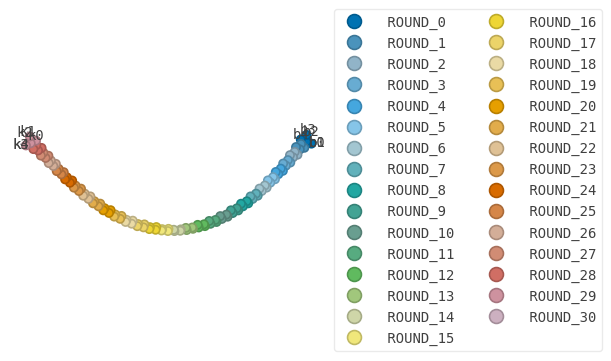

In [2]:
pqc_circuit = qu.load_from_disk("data/optimised_PQC")
pqc_circuit_unitary = pqc_circuit.get_uni(
    transposed=False
)  # Convert PQC into a graph that can be visualised.
pqc_circuit_unitary.draw(color=[f"ROUND_{i}" for i in range(30 + 1)], show_inds=True)

### Initialise State

Here, the state representing the initial wavefield, $|\psi(x,t=0)\rangle$, is computed for both the position and velocity spaces.
We choose $f(x)$ to be represented by a Gaussian function with $\mu = 0.5$ and $\sigma = 0.025$, whilst the initial velocity is zero everywhere.

In [3]:
def gaussian(x, mu=0.5, sigma=0.025):
    """Gaussian function for initial state.

    Args:
      x: Float or array: Point or discretised solution space.
      mu: Float: Mean of Gaussian.
      sigma: Float: Standard deviation of Gaussian.
    """
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def initialise_state(N, x0=0, xL=1):
    """Initialise state, psi_0(t=0,x) = (psi_P(0,x), psi_V(0,x)), for all points on the grid.
    psi_P represents the position space whilst psi_V represents the velocity space.
    Grid space defined by starting and finishing points, x0 and xL,
    and number of grid points, N = 2^n, where n is the number of qubits.

    Args:
      N: int: Number of grid points.
      x0: Float: Starting point of discretised space.
      xL: Float: End point of discretised space.
    """
    psi = np.zeros(2 * N)

    # Grid space
    xs = np.linspace(x0, xL, num=N)

    # psi_P initialised as a Gaussian at t=0
    psi_P = np.array(gaussian(xs))

    # psi_V initialised as 0 at t=0
    psi_V = np.zeros(psi.shape[0] - N)

    psi[: len(psi_P)] = psi_P
    psi[len(psi_P) : len(psi_P) + len(psi_V)] = psi_V

    # Normalise state
    psi /= np.linalg.norm(psi)

    return psi

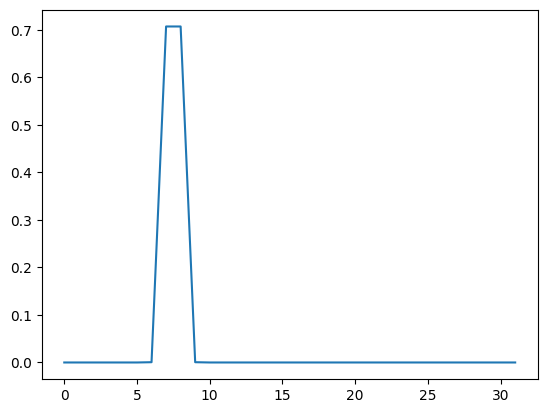

In [4]:
# Plot ampltiudes of wave function, |psi_0(t=0,x)>.
N = 2 ** (pqc_circuit.N - 1)  # Number of qubits defined by size of PQC.
psi_0 = initialise_state(N)
plt.plot(psi_0)

### Evolve State
Evolve the state in time using the PQC optimised to represent $U = e^{-i \Delta t H}$, where $\Delta t = 0.01$.

In [5]:
dt = 0.01
ts = [dt * i for i in range(1, 1001)]
U_evo = pqc_circuit_unitary.to_dense()

# Evolve states with PQC U
psi_ts = [psi_0]
for _ in ts:
    psi_t = U_evo @ psi_ts[-1]
    psi_ts.append(psi_t)

psi_ts = (
    abs(np.array(psi_ts)[1:]) ** 2
)  # Solution given by the amplitude squared of the wavefunction.

### Plot solution
Plot the solution obtained computed by quantum algorithm.
Please find the `.gif` in the `data/` directory since they do not show in notebooks.

MovieWriter ffmpeg unavailable; using Pillow instead.


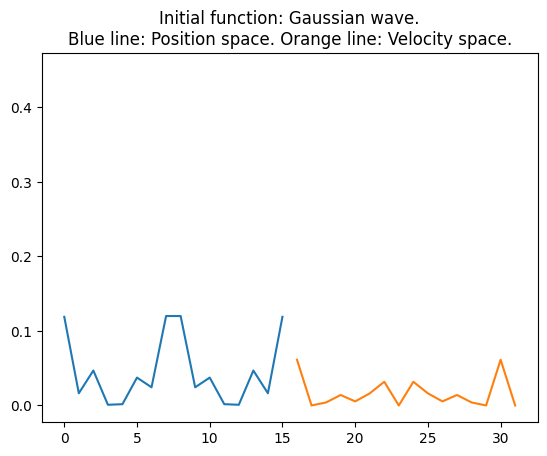

In [6]:
def plot(phi):
    fig = plt.figure()
    plts = []  

    for i in range(len(phi)):
        (p1,) = plt.plot(np.append(phi[i, :N], [None] * N), "tab:blue")
        (p2,) = plt.plot(np.append([None] * N, phi[i, N:]), "tab:orange")
        plts.append([p1, p2])

    ani = animation.ArtistAnimation(
        fig, plts, interval=10, repeat_delay=3000
    )  # run the animation
    plt.title(
        "Initial function: Gaussian wave.\nBlue line: Position space. Orange line: Velocity space."
    )
    ani.save("data/gaussian_evolution.gif")


plot(psi_ts)

## TKET Circuit Simulation

In this section we use `TKET` to optimise the compilation, and remove redundancies from our circuits.
This allows us to obtain more accurate results when running our circuits in the presence of noise.
In addition, `TKET` allows us to easily represent our circuit in a variety of different gatesets, making the circuits hardware agnostic.

### Convert Quimb PQC into TKET circuit
Convert PQC into circuit using `TKET`'s `Unitary2qBox` function.
Since the PQC is a brickwall circuit with general $SU4$ unitaries, `Unitary2qBox` converts their respective matrices into general $SU4$ gates without any need to decompose into native gates.

In [7]:
def unitary_box_quimb_to_tket(circ):

    t_circ = Circuit(circ.N)  # Define TKET circuit.
    for gate in circ.gates:  # Iterate over gates in PQC.
        matrix = gate.array.data.reshape(4, 4)
        unitary_box = Unitary2qBox(matrix)
        t_circ.add_unitary2qbox(
            unitary_box, *gate.qubits
        )  # Add unitary box to circuit.

    return t_circ

### Plot `TKET` circuits
In notebooks, we can display an interactive circuit diagram using `TKET`.

In [8]:
t_circ = unitary_box_quimb_to_tket(pqc_circuit)  # Define circuit
render_circuit_jupyter(t_circ)  # Render diagram

### Optimise Circuit Compilation
Optimise the number of fundamental gates within our `TKET` circuits.

#### Decompose Boxes
The `DecomposeBoxes()` method decomposes a `TKET` circuit into fundamental gates of a particular gateset that includes general single qubit (`TK1`) and two qubit (`TK2`) gates.

In [9]:
DecomposeBoxes().apply(t_circ)
render_circuit_jupyter(t_circ)  # Render interactive circuit diagram

#### Compile circuits
Compile the circuits with different levels of optimisations.
This requires specifying a particular backend in order to acquire the available gates within that backend.
For `optimisation_level = 0` using the `AerBackend()`, compilation passes such as, but not limited to, `RemoveRedundancies()` are applied to the circuit.
For `optimisation_level = 2`, even more compilation passes are applied to the circuit such as `FullPeepholeOptimise()` and `CliffordSimp(allow_swaps=False)`.
A full list of all the compilation passes using the `AerBackend()` can be found [here](https://cqcl.github.io/pytket-qiskit/api/index.html#backends-available-through-pytket-qiskit).

In [10]:
backend = AerBackend()  # Get backend
non_opt_circ = backend.get_compiled_circuit(t_circ, optimisation_level=0)
opt_circ = backend.get_compiled_circuit(t_circ, optimisation_level=2)

# Count the number of gates for the non-opt and opt circuits
print(gate_counts(non_opt_circ))
print(gate_counts(opt_circ))

Counter({<OpType.TK1: 40>: 1200, <OpType.SX: 31>: 416, <OpType.X: 23>: 410, <OpType.CX: 42>: 360, <OpType.Z: 22>: 306, <OpType.Y: 24>: 126, <OpType.Sdg: 26>: 100, <OpType.S: 25>: 100})
Counter({<OpType.TK1: 40>: 725, <OpType.CX: 42>: 360})


#### Rebase to same gateset
Optimising the compilation of circuits changes the gateset. 
Therefore, we rebase both the non-optimised and optimised circuits to the same gateset in order to fairly compare circuits.
Note that changing gatesets sometimes introduces redundancies, therefore the `RemoveRedundancies()` should be applied after rebasing.

We can see after rebasing, the optimised circuit has roughly 50% less single qubit gates!
We can also visualise our rebased circuits interactively. 

In [11]:
gateset = {OpType.H, OpType.Rz, OpType.ZZPhase}  # Define particular univseral gateset/
custom = auto_rebase_pass(gateset)  # Allow TKET to perform the rebase.

custom.apply(non_opt_circ)  # Apply to non-opt circ
custom.apply(opt_circ)  # Apply to opt circ

# Remove redundancies, since rebasing can introduce redundancies.
RemoveRedundancies().apply(non_opt_circ)
RemoveRedundancies().apply(opt_circ)

print("non-opt circ: ", gate_counts(non_opt_circ))
print("opt circ: ", gate_counts(opt_circ))
render_circuit_jupyter(opt_circ)

non-opt circ:  Counter({<OpType.H: 33>: 3924, <OpType.Rz: 36>: 3899, <OpType.ZZPhase: 71>: 360})
opt circ:  Counter({<OpType.Rz: 36>: 2061, <OpType.H: 33>: 2057, <OpType.ZZPhase: 71>: 360})


### Noisy Simulation
Simulate the compiled circuits within a noisy environment --- here we can observe the advantages of optimising the circuits to have lower gate counts.

#### Define sample circuit
Construct an end-to-end circuit for the simulation of the wave equation. 
This includes:
1. State-preparation.
2. Evolutionary operator.
3. Sampling $|\psi(x,t)\rangle$.

`TKET` contains a state-preparation box for preparing quantum states using multiplexed-Ry and multiplexed-Rz gates from an input array _i.e._ $|\psi(x,t=0)\rangle$.

In [12]:
sample_circ = Circuit(t_circ.n_qubits)

# Add state preparation to start of circuit
sp_box = StatePreparationBox(psi_0)
sample_circ.add_state_preparation_box(sp_box, range(sample_circ.n_qubits))

# Add t_circ as a CircBox
t_circ_box = CircBox(t_circ)
sample_circ.add_circbox(t_circ_box, range(t_circ.n_qubits))

# Add measurements to end of circuit
sample_circ.measure_all()

render_circuit_jupyter(sample_circ)

In [13]:
# Optimise circuits once again, with state preparation attached
sample_non_opt_circ = backend.get_compiled_circuit(sample_circ, optimisation_level=0)
sample_opt_circ = backend.get_compiled_circuit(sample_circ, optimisation_level=2)

# Rebase circuit, ensures that both circuits have same gateset
gateset = {OpType.U3, OpType.CX}
custom = auto_rebase_pass(gateset)

custom.apply(sample_non_opt_circ)
RemoveRedundancies().apply(sample_non_opt_circ)
custom.apply(sample_opt_circ)
RemoveRedundancies().apply(sample_opt_circ)


print("non-opt circ: ", gate_counts(sample_non_opt_circ))
print("opt circ: ", gate_counts(sample_opt_circ))

non-opt circ:  Counter({<OpType.U3: 37>: 2688, <OpType.CX: 42>: 390, <OpType.Measure: 61>: 5})
opt circ:  Counter({<OpType.U3: 37>: 755, <OpType.CX: 42>: 390, <OpType.Measure: 61>: 5})


#### Create depolarise noise model
Add depolarising noise to the single qubits gates _only_ within our non-optimised and optimised circuits.
Specific details on the depolarising error used in this tutorial can be found [here](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.noise.depolarizing_error.html).

In [14]:
depolarising_noise_model = NoiseModel()
error = depolarizing_error(2e-3, 1)
for q in range(sample_non_opt_circ.n_qubits):
    depolarising_noise_model.add_quantum_error(error, ["u"], [q])
print(depolarising_noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u']
  Instructions with noise: ['u']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('u', (0,)), ('u', (1,)), ('u', (2,)), ('u', (3,)), ('u', (4,))]


#### Run noisy simulation
Sample non-optimised and optimised circuits in the presence of depolarising noise.

In [16]:
shots = 2**10  # Number of shots (samples) for our simulation.
noisy_backend = AerBackend(
    noise_model=depolarising_noise_model
)  # Define noisy backend.

# Apply noise model to non-opt circuit.
non_opt_noisy_handle = noisy_backend.process_circuit(
    sample_non_opt_circ, n_shots=shots, seed=1, valid_check=False
)
non_opt_noisy_counts = noisy_backend.get_result(non_opt_noisy_handle).get_counts()
non_opt_noisy_counts

Counter({(0, 0, 0, 0, 1): 48,
         (1, 1, 1, 1, 0): 48,
         (0, 1, 1, 0, 1): 41,
         (0, 0, 1, 1, 1): 39,
         (0, 1, 1, 0, 0): 39,
         (0, 1, 1, 1, 1): 37,
         (0, 0, 1, 0, 0): 36,
         (1, 0, 1, 0, 1): 36,
         (0, 0, 0, 1, 1): 35,
         (0, 1, 0, 0, 0): 35,
         (0, 1, 1, 1, 0): 35,
         (1, 1, 0, 0, 1): 35,
         (0, 0, 1, 0, 1): 34,
         (0, 1, 0, 0, 1): 34,
         (1, 1, 1, 0, 0): 34,
         (1, 1, 1, 1, 1): 34,
         (1, 0, 1, 1, 0): 33,
         (0, 1, 0, 1, 0): 31,
         (1, 0, 0, 0, 1): 30,
         (1, 1, 1, 0, 1): 30,
         (0, 0, 0, 1, 0): 29,
         (1, 1, 0, 1, 0): 29,
         (1, 0, 0, 1, 1): 28,
         (1, 1, 0, 0, 0): 27,
         (0, 0, 1, 1, 0): 26,
         (1, 0, 0, 0, 0): 26,
         (0, 0, 0, 0, 0): 24,
         (1, 1, 0, 1, 1): 24,
         (1, 0, 0, 1, 0): 23,
         (1, 0, 1, 1, 1): 23,
         (0, 1, 0, 1, 1): 22,
         (1, 0, 1, 0, 0): 19})

In [17]:
# Apply noise model to opt circuit.
opt_noisy_handle = noisy_backend.process_circuit(
    sample_opt_circ, n_shots=shots, seed=1, valid_check=False
)
opt_noisy_counts = noisy_backend.get_result(opt_noisy_handle).get_counts()
opt_noisy_counts

Counter({(0, 1, 0, 0, 0): 157,
         (0, 0, 1, 1, 1): 148,
         (1, 1, 0, 0, 0): 47,
         (1, 0, 1, 1, 0): 43,
         (0, 0, 0, 0, 1): 34,
         (0, 1, 1, 1, 0): 33,
         (0, 0, 0, 1, 1): 30,
         (0, 0, 1, 0, 1): 28,
         (0, 1, 0, 0, 1): 28,
         (1, 1, 1, 1, 1): 27,
         (0, 1, 1, 0, 1): 26,
         (1, 1, 1, 1, 0): 26,
         (1, 0, 1, 1, 1): 25,
         (0, 0, 1, 1, 0): 24,
         (1, 0, 0, 1, 1): 23,
         (1, 0, 1, 0, 1): 23,
         (1, 1, 0, 1, 0): 23,
         (0, 0, 0, 0, 0): 22,
         (1, 1, 0, 0, 1): 22,
         (1, 1, 0, 1, 1): 22,
         (1, 1, 1, 0, 0): 21,
         (0, 0, 1, 0, 0): 20,
         (0, 1, 0, 1, 1): 20,
         (1, 0, 0, 1, 0): 20,
         (1, 0, 1, 0, 0): 20,
         (1, 1, 1, 0, 1): 20,
         (0, 1, 1, 1, 1): 19,
         (0, 1, 0, 1, 0): 18,
         (0, 0, 0, 1, 0): 17,
         (1, 0, 0, 0, 1): 16,
         (0, 1, 1, 0, 0): 14,
         (1, 0, 0, 0, 0): 8})

#### Create and run noiseless circuit
Create and run a noiseless circuit in order to have a reference point to compare the noisy simulations to --- since both simulations contain sampling noise due to the finite number of shots.
Since there is no gate error, it does not matter whether we use the non-optimised and optimised circuits.


In [18]:
# Sample circuits
noiseless_handle = backend.process_circuit(sample_opt_circ, n_shots=shots, seed=1)
noiseless_counts = backend.get_result(noiseless_handle).get_counts()
noiseless_counts

Counter({(0, 0, 1, 1, 1): 465,
         (0, 1, 0, 0, 0): 418,
         (1, 1, 0, 0, 0): 72,
         (1, 0, 1, 1, 0): 64,
         (0, 0, 1, 1, 0): 3,
         (0, 1, 0, 0, 1): 2})

#### Plot results
Plot noiseless and noisy results for one time-step of the wave equation, using non-optimised and optimised circuits.
This requires us to convert the counts into statevectors before plotting the results. 

In [19]:
# Match counts to respective bitstrings
bitstrings = [
    format(i, f"0{sample_circ.n_qubits}b") for i in range(2**sample_circ.n_qubits)
]


def from_counts_to_array(counts):
    """Convert counts into statevector.

    Args:
      counts: Dict: Keys represent bitstrings. Values represent number of times measured.
    """
    counts_strings = [
        f"{i}".replace(",", "").replace("(", "").replace(")", "").replace(" ", "")
        for i in counts.keys()
    ]
    counts_values = list(counts.values())
    statevector = [
        sum(
            [
                k / sum(counts_values) if i == j else 0
                for i, k in zip(counts_strings, counts_values)
            ]
        )
        for j in bitstrings
    ]
    return statevector


noiseless_bitstring_counts = from_counts_to_array(noiseless_counts)
non_opt_noisy_bitstring_counts = from_counts_to_array(non_opt_noisy_counts)
opt_noisy_bitstring_counts = from_counts_to_array(opt_noisy_counts)

In [20]:
def plot_differences(noiseless_counts, noisy_counts, label):
    # Plot differences
    ind = np.arange(2**sample_non_opt_circ.n_qubits)
    width = 0.3
    plt.bar(ind, noiseless_counts, width, label="Noiseless")
    plt.bar(
        ind + width,
        noisy_counts,
        width,
        label=f"Noisy {label}",
    )

    plt.xticks(ind + width / 2, bitstrings)
    plt.yscale("log")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Bitstrings")
    plt.ylabel("Amplitude squared of bitstring")
    plt.legend()

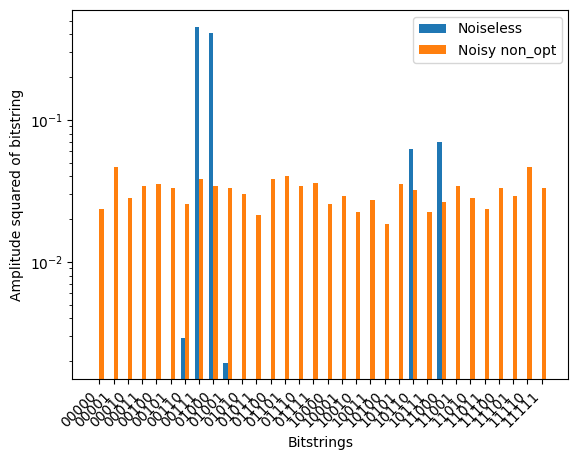

In [21]:
# Noiseless vs non-opt noisy results.
plot_differences(noiseless_bitstring_counts, non_opt_noisy_bitstring_counts, "non_opt")

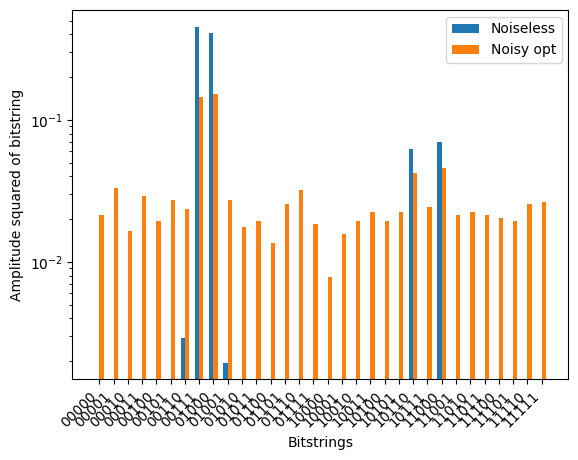

In [22]:
# Noiseless vs opt noisy results.
plot_differences(noiseless_bitstring_counts, opt_noisy_bitstring_counts, "opt")

### Conclusion
In this notebook we have shown that `TKET` has allowed us to optimise the compilation of circuits, leading to a more accurate simulation of the wave equation when compared to the noiseless results.